In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import cv2

In [2]:
def resize_with_aspect_ratio(image, MAX_SIZE):

    H, W = image.shape[0:2]
    
    # Take the greater value, and use it for the ratio
    max_ = np.min([H, W])
    ratio = max_ / MAX_SIZE

    W_ = W / ratio
    H_ = H / ratio

    W_, H_ = W_.astype(np.int32), H_.astype(np.int32)
    image = cv2.resize(image, (W_,H_), interpolation=cv2.INTER_AREA)
    
    H, W = image.shape[0:2]
    
    if H > MAX_SIZE:
        margin = H - MAX_SIZE
        start_y = margin // 2
        image = image[start_y:start_y+MAX_SIZE, 0:W]
    elif W > MAX_SIZE:
        margin = W - MAX_SIZE
        start_y = margin // 2
        image =  image[:H, start_y: start_y+MAX_SIZE]
    return image

In [3]:
def process_tfds(features):
    image = features["image"]
    target = features["label"]
    return tf.cast(image, tf.float32), tf.squeeze(target)

In [4]:
train_dataset = tfds.load(name="imagenet2012", split=tfds.Split.TRAIN)
train_dataset = train_dataset.map(process_tfds)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.batch(1)

In [5]:
classes_dog_and_cat = np.arange(151, 294, dtype=np.int32)

class_to_index = dict()
for i, c in enumerate(classes_dog_and_cat):
    class_to_index[c] = i

In [33]:
class_to_index[286]

135

In [6]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [7]:
import os
import tensorflow as tf

TRAIN_DATASET_DIR="./tfrecords/"
if not os.path.exists(TRAIN_DATASET_DIR):
    os.mkdir(TRAIN_DATASET_DIR)
    
TRAIN_FILE = 'train.tfrecords'
train_writer = tf.io.TFRecordWriter(os.path.join(TRAIN_DATASET_DIR,TRAIN_FILE))

In [8]:
n_images = 0
image_size = 64

for image, label in train_dataset:
    label = label.numpy()[0]
    if label in classes_dog_and_cat:
        image = resize_with_aspect_ratio(image.numpy()[0], image_size)
    
        image_h = image.shape[0]
        image_w = image.shape[1]
        img_raw = image.astype(np.float32).tostring()
        target = class_to_index[label]

        example = tf.train.Example(features=tf.train.Features(feature={
                                    'height': _int64_feature(image_h),
                                    'width': _int64_feature(image_w),
                                    'image_raw': _bytes_feature(img_raw),
                                    'target': _int64_feature(target)}))

        train_writer.write(example.SerializeToString())
        n_images+=1
        
print("Done!")
train_writer.close()

Done!


In [9]:
n_images

180373

In [19]:
def tf_record_parser(record):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'target': tf.io.FixedLenFeature((), tf.int64)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    image = tf.io.decode_raw(features['image_raw'], tf.float32)
    label = tf.cast(features['target'], tf.int32)

    # reshape input and annotation images
    image = tf.reshape(image, (64, 64, 3), name="image_reshape")

    return image, tf.cast(label, tf.int32)

In [20]:
train_dataset = tf.data.TFRecordDataset("./tfrecords/train.tfrecords")
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.batch(1)

In [38]:
classes = []
for image, label in train_dataset:
    if label.numpy()[0] == 133:
        print(np.min(image), np.max(image))
        plt.imshow(image[0]/255)
        plt.show()

20.47129 254.4475


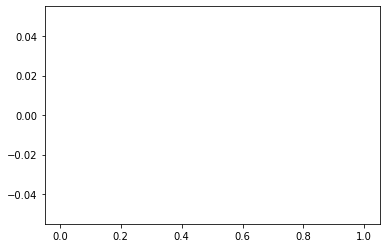

In [37]:
_ = plt.hist(classes, bins=143)